# Lab 10-2: YOLO for Object Detection
## Exercise: Car Detection
This exercise is originated from a COURSERA notebook,<br>
but a large portion of code is modified for a new model architecture and TensorFlow 2.x.<br>
Check the following link if you are interested in COURSERA materials.<br>
https://github.com/enggen/Deep-Learning-Coursera/


### Import libraries

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os

In this exercise, you will learn how "You Only Look Once" (YOLO) performs object detection, and then apply it to car detection. Because the YOLO model is very computationally expensive to train, we will load pre-trained weights for you to use. 

## 1 - YOLO

"You Only Look Once" (YOLO) is a popular algorithm because it achieves high accuracy while also being able to run in real-time. This algorithm "only looks once" at the image in the sense that it requires only one forward propagation pass through the network to make predictions. After non-max suppression, it then outputs recognized objects together with the bounding boxes.

### 1.1 - Model details

#### Inputs and outputs
- The **input** is a batch of images, and each image has the shape (m, 608, 608, 3)
- The **output** is a list of bounding boxes along with the recognized classes. Each bounding box is represented by 6 numbers $( b_y, b_x, b_h, b_w, c, p_c)$. If you expand $c$ into an 80-dimensional vector, each bounding box is then represented by 85 numbers. 

#### Anchor Boxes
* Anchor boxes are chosen by exploring the training data to choose reasonable height/width ratios that represent the different classes.  For this assignment, 5 anchor boxes were chosen for you (to cover the 80 classes).

* The dimension for anchor boxes is the second to last dimension in the encoding: $(m, n_H,n_W,anchors,classes)$.
* The YOLO architecture is: IMAGE (m, 608, 608, 3) -> DEEP CNN -> ENCODING (m, 19, 19, 5, 85).  

#### Class score

Now, for each box (of each cell) we will compute the following element-wise product and extract a probability that the box contains a certain class.  
The class score is $score_{c,i} = p_{c} \times c_{i}$: the probability that there is an object $p_{c}$ times the probability that the object is a certain class $c_{i}$.


##### Example
* Let's say for box 1 (cell 1), the probability that an object exists is $p_{1}=0.60$.  So there's a 60% chance that an object exists in box 1 (cell 1).  
* The probability that the object is the class "category 3 (a car)" is $c_{3}=0.73$.  
* The score for box 1 and for category "3" is $score_{1,3}=0.60 \times 0.73 = 0.44$.  
* Let's say we calculate the score for all 80 classes in box 1, and find that the score for the car class (class 3) is the maximum.  So we'll assign the score 0.44 and class "3" to this box "1".

### 1.2 - Filtering with a threshold on class scores

You are going to first apply a filter by thresholding. You would like to get rid of any box for which the class "score" is less than a chosen threshold. 

The model gives you a total of 19x19x5x85 numbers, with each box described by 85 numbers. It is convenient to rearrange the (19,19,5,85) dimensional tensor into the following variables:  
- `box_confidence`: tensor of shape $(19 \times 19, 5, 1)$ containing $p_c$ (confidence probability that there's some object) for each of the 5 boxes predicted in each of the 19x19 cells.
- `boxes`: tensor of shape $(19 \times 19, 5, 4)$ containing the midpoint and dimensions $(b_x, b_y, b_h, b_w)$ for each of the 5 boxes in each cell.
- `box_class_probs`: tensor of shape $(19 \times 19, 5, 80)$ containing the "class probabilities" $(c_1, c_2, ... c_{80})$ for each of the 80 classes for each of the 5 boxes per cell.

Many YOLO implementation have a module called `yolo_head` to split output features into several tensors.

In [43]:
def yolo_head(feats, anchors, num_classes):
    """Convert final layer features to bounding box parameters.

    Parameters
    ----------
    feats : tensor = (b, 19, 19, 5, 85) = (b,g,g,a,c+p)
        Final convolutional layer features.
    anchors : array-like = (10,)
        Anchor box widths and heights.
    num_classes : int = 20
        Number of target classes.

    Returns
    -------
    box_xy : tensor
        x, y box predictions adjusted by spatial location in conv layer.
    box_wh : tensor
        w, h box predictions adjusted by anchors and conv spatial resolution.
    box_conf : tensor
        Probability estimate for whether each box contains any object.
    box_class_pred : tensor
        Probability distribution estimate for each box over class labels.
    """
    
    # Reshape to batch, height, width, num_anchors, box_params.
    num_anchors = int(len(anchors)/2)                                # = 5
    anchors_tensor = tf.reshape(anchors, [1, 1, 1, num_anchors, 2])  # (1,1,1,5,2)

    # Generation of grid_index:
    grid_dims = tf.shape(feats)[1:3]            # grid dimension; assuming channels last = [gh,gw]
    idx_no0 = tf.expand_dims(tf.range(0, grid_dims[0], dtype=tf.float32), axis=-1)       # (gh, 1)
    idx_no1 = tf.expand_dims(tf.repeat(idx_no0, repeats=grid_dims[1], axis=-1), axis=-1) # (gh, gw, 1)
    idx_no2 = tf.transpose(idx_no1, [1,0,2])                                             # (gw, gh, 1)
    idx_no3 = tf.concat([idx_no1,idx_no2], axis=-1)                                      # (gh, gw, 2) -> last dim (h,w)
    idx_arr = tf.reshape(idx_no3, [1, grid_dims[0], grid_dims[1], 1, 2])                 # (1, gh, gw, 1, 2)
    grid_index = tf.cast(idx_arr, dtype=feats.dtype)

    feats = tf.reshape(
        feats, [-1, grid_dims[0], grid_dims[1], num_anchors, num_classes + 5])

    # expand grid dimension to match feature dimension
    grid_divs = tf.cast(tf.reshape(grid_dims, [1, 1, 1, 1, 2]), dtype=feats.dtype)

    ### START CODE HERE ### 

    box_yx = tf.sigmoid(feats[..., :2])                  # convert feature values for y & x
    box_hw = tf.exp(feats[..., 2:4])                  # convert feature values for h & w
    box_confidence = tf.sigmoid(feats[..., 4:5])          # calculate object confidence
    box_class_probs = tf.nn.softmax(feats[..., 5:])         # find class probability

    # Adjust preditions to each spatial grid point and anchor size.
    # don't forget the final values should be within the range of [0,1]
    box_yx = (box_yx + grid_index) / grid_divs
    box_hw = box_hw * anchors_tensor / grid_divs

    ###  END CODE HERE  ###

    return box_confidence, box_yx, box_hw, box_class_probs

#### **Exercise**: Implement `yolo_filter_boxes()`.
1. Compute box scores by doing the elementwise product.  

2. For each box, find:
    - the index of the class with the maximum box score
    - the corresponding box score
    
    **Useful references**
        * For the `axis` parameter of `argmax` and `max`, if you want to select the **last** axis, one way to do so is to set `axis=-1`.  This is similar to Python array indexing, where you can select the last position of an array using `arrayname[-1]`.
        * Applying `max` normally collapses the axis for which the maximum is applied.  `keepdims=False` is the default option, and allows that dimension to be removed.  We don't need to keep the last dimension after applying the maximum here.
        * Even though the documentation shows `keras.backend.argmax`, use `keras.argmax`.  Similarly, use `keras.max`.


3. Create a mask by using a threshold. As a reminder: `([0.9, 0.3, 0.4, 0.5, 0.1] < 0.4)` returns: `[False, True, False, False, True]`. The mask should be True for the boxes you want to keep. 

4. Use TensorFlow to apply the mask to `box_class_scores`, `boxes` and `box_classes` to filter out the boxes we don't want. You should be left with just the subset of boxes you want to keep. This will change the tensor shape to the output tensor dimensions.

    **Useful reference**:
    * [boolean mask](https://www.tensorflow.org/api_docs/python/tf/boolean_mask)  

   **Additional Hints**:  
    * For the `tf.boolean_mask`, we can keep the default `axis=None`.

In [3]:
def yolo_filter_boxes(box_confidence, boxes, box_class_probs, threshold = .6):
    """Filters YOLO boxes by thresholding on object and class confidence.
    
    Arguments:
    box_confidence -- tensor of shape (19, 19, 5, 1)
    boxes -- tensor of shape (19, 19, 5, 4)
    box_class_probs -- tensor of shape (19, 19, 5, 80)
    threshold -- real value, if [ highest class probability score < threshold], then get rid of the corresponding box
    
    Returns:
    scores -- tensor of shape (None,), containing the class probability score for selected boxes
    boxes -- tensor of shape (None, 4), containing (b_x, b_y, b_h, b_w) coordinates of selected boxes
    classes -- tensor of shape (None,), containing the index of the class detected by the selected boxes
    
    Note: "None" is here because you don't know the exact number of selected boxes, as it depends on the threshold. 
    For example, the actual output size of scores would be (10,) if there are 10 boxes.
    """
    
    # Step 1: Compute box scores
    ### START CODE HERE ###

    box_scores = box_confidence * box_class_probs
    
    ###  END CODE HERE  ###
    
    # Step 2: Find the box_classes using the max box_scores, keep track of the corresponding score
    ### START CODE HERE ### 

    box_classes = tf.argmax(box_scores, axis=-1)
    box_class_scores = tf.reduce_max(box_scores, axis=-1)
    
    ###  END CODE HERE  ###
    
    # Step 3: Create a boolean filtering mask based on "box_class_scores" by using "threshold". 
    # The mask should have the same dimension as box_class_scores, 
    # and be True for the boxes you want to keep (with probability >= threshold)
    ### START CODE HERE ### 

    filtering_mask = box_class_scores >= threshold#tf.greater_equal(box_class_scores, threshold)

    ###  END CODE HERE  ###
    
    # Step 4: Apply the mask to box_class_scores, boxes and box_classes
    ### START CODE HERE ###

    scores = tf.boolean_mask(box_class_scores, filtering_mask)
    boxes = tf.boolean_mask(boxes, filtering_mask)
    classes = tf.boolean_mask(box_classes, filtering_mask)
    
    ###  END CODE HERE  ###
    
    return scores, boxes, classes

In [4]:
tf.random.set_seed(1)
box_confidence = tf.random.normal([19, 19, 5, 1], mean=1, stddev=4)
boxes = tf.random.normal([19, 19, 5, 4], mean=1, stddev=4)
box_class_probs = tf.random.normal([19, 19, 5, 80], mean=1, stddev=4)
scores, boxes, classes = yolo_filter_boxes(box_confidence, boxes, box_class_probs, threshold = 0.5)
print("scores[2] = " + str(scores[2].numpy()))
print("boxes[2] = " + str(boxes[2].numpy()))
print("classes[2] = " + str(classes[2].numpy()))
print("scores.shape = " + str(scores.shape))
print("boxes.shape = " + str(boxes.shape))
print("classes.shape = " + str(classes.shape))

scores[2] = 26.991379
boxes[2] = [-4.0077353  1.0848972 -1.2055032 -5.972679 ]
classes[2] = 43
scores.shape = (1784,)
boxes.shape = (1784, 4)
classes.shape = (1784,)


**Expected Output**:
```
scores[2] = 26.991379
boxes[2] = [-4.0077353  1.0848972 -1.2055032 -5.972679 ]
classes[2] = 43
scores.shape = (?,)
boxes.shape = (?, 4)
classes.shape = (?,)
```

**Note** In the test for `yolo_filter_boxes`, we're using random numbers to test the function.  In real data, the `box_class_probs` would contain non-zero values between 0 and 1 for the probabilities.  The box coordinates in `boxes` would also be chosen so that lengths and heights are non-negative.

### 1.3 - Non-max suppression ###

Even after filtering by thresholding over the class scores, you still end up with a lot of overlapping boxes. You'd like to reduce the algorithm's output to a much smaller number of detected objects. 

To do so, you'll use **non-max suppression**, a second filter for selecting the right boxes. Specifically, you'll carry out these steps: 
- Get rid of boxes with a low score (meaning, the box is not very confident about detecting a class; either due to the low probability of any object, or low probability of this particular class).
- Select only one box when several boxes overlap with each other and detect the same object.

**Note** `tf.image.non_max_suppression` also has `score_threshold` argument which filters low score boxed as you did in the previous exercise.


Non-max suppression uses the very important function called **"Intersection over Union"**, or IoU.


#### **Exercise**: Implement iou(). Some hints:
- In this code, we use the convention that (0,0) is the top-left corner of an image, (1,0) is the upper-right corner, and (1,1) is the lower-right corner. In other words, the (0,0) origin starts at the top left corner of the image. As x increases, we move to the right.  As y increases, we move down.
- For this exercise, we define a box using its two corners: upper left $(x_1, y_1)$ and lower right $(x_2,y_2)$, instead of using the midpoint, height and width. (This makes it a bit easier to calculate the intersection).
- To calculate the area of a rectangle, multiply its height $(y_2 - y_1)$ by its width $(x_2 - x_1)$. (Since $(x_1,y_1)$ is the top left and $x_2,y_2$ are the bottom right, these differences should be non-negative.
- To find the **intersection** of the two boxes $(xi_{1}, yi_{1}, xi_{2}, yi_{2})$: 
    - Feel free to draw some examples on paper to clarify this conceptually.
    - The top left corner of the intersection $(xi_{1}, yi_{1})$ is found by comparing the top left corners $(x_1, y_1)$ of the two boxes and finding a vertex that has an x-coordinate that is closer to the right, and y-coordinate that is closer to the bottom.
    - The bottom right corner of the intersection $(xi_{2}, yi_{2})$ is found by comparing the bottom right corners $(x_2,y_2)$ of the two boxes and finding a vertex whose x-coordinate is closer to the left, and the y-coordinate that is closer to the top.
    - The two boxes **may have no intersection**.  You can detect this if the intersection coordinates you calculate end up being the top right and/or bottom left corners of an intersection box.  Another way to think of this is if you calculate the height $(y_2 - y_1)$ or width $(x_2 - x_1)$ and find that at least one of these lengths is negative, then there is no intersection (intersection area is zero).  
    - The two boxes may intersect at the **edges or vertices**, in which case the intersection area is still zero.  This happens when either the height or width (or both) of the calculated intersection is zero.


**Additional Hints**

- `xi1` = **max**imum of the x1 coordinates of the two boxes
- `yi1` = **max**imum of the y1 coordinates of the two boxes
- `xi2` = **min**imum of the x2 coordinates of the two boxes
- `yi2` = **min**imum of the y2 coordinates of the two boxes
- `inter_area` = You can use `max(height, 0)` and `max(width, 0)`

**Note** At the early stage of training, the coordinates are meaningless and the area could be negative. You have to filter the erroneous results.


In [8]:
def iou(box1, box2):
    """Implement the intersection over union (IoU) between box1 and box2

    Arguments:
    box1 -- first box, list object with coordinates  (box1_y1, box1_x1, box1_y2, box1_x2)
    box2 -- second box, list object with coordinates (box2_y1, box2_x1, box2_y2, box2_x2)
    """

    # Assign variable names to coordinates for clarity
    box1_yx1 = box1[...,0:2]
    box1_yx2 = box1[...,2:4]
    box2_yx1 = box2[...,0:2]
    box2_yx2 = box2[...,2:4]
    
    box1_hws = box1_yx2 - box1_yx1
    box2_hws = box2_yx2 - box2_yx1

    # Calculate the (yi1, xi1, yi2, xi2) coordinates of the intersection of box1 and box2. Calculate its Area.
    ### START CODE HERE ### 

    ints_yx1 = tf.maximum(box1_yx1, box2_yx1)      # start corner of intersection box
    ints_yx2 = tf.minimum(box1_yx2, box2_yx2)      # end corner of intersection box

    # filter out the case in which they don't intersec --> max(,0)
    ints_hws = tf.maximum(ints_yx2-ints_yx1, tf.constant([0.0,0.0]))     

    # calculate intersection area
    inter_area = tf.reduce_prod(ints_hws)
    
    ###  END CODE HERE  ###    

    # Calculate the Union area by using Formula: Union(A,B) = A + B - Inter(A,B)
    ### START CODE HERE ###

    box1_area = tf.reduce_prod(box1_hws)
    box2_area = tf.reduce_prod(box2_hws)
    union_area = box1_area + box2_area - inter_area
    
    ###  END CODE HERE  ###
    
    # compute the IoU
    ### START CODE HERE ###
    
    iou = inter_area / union_area       # iou can be unstable at the early stage of training

    ###  END CODE HERE  ###
    
    return iou

In [9]:
## Test case 1: boxes intersect
box1 = tf.constant([2, 1, 4, 3], dtype=tf.float32)
box2 = tf.constant([1, 2, 3, 4], dtype=tf.float32) 
print("iou for intersecting boxes = " + str(iou(box1, box2).numpy()))

## Test case 2: boxes do not intersect
box1 = tf.constant([1,2,3,4], dtype=tf.float32)
box2 = tf.constant([5,6,7,8], dtype=tf.float32)
print("iou for non-intersecting boxes = " + str(iou(box1,box2).numpy()))

## Test case 3: boxes intersect at vertices only
box1 = tf.constant([1,1,2,2], dtype=tf.float32)
box2 = tf.constant([2,2,3,3], dtype=tf.float32)
print("iou for boxes that only touch at vertices = " + str(iou(box1,box2).numpy()))

## Test case 4: boxes intersect at edge only
box1 = tf.constant([1,1,3,3], dtype=tf.float32)
box2 = tf.constant([2,3,3,4], dtype=tf.float32)
print("iou for boxes that only touch at edges = " + str(iou(box1,box2).numpy()))

iou for intersecting boxes = 0.14285715
iou for non-intersecting boxes = 0.0
iou for boxes that only touch at vertices = 0.0
iou for boxes that only touch at edges = 0.0


**Expected Output**:

```
iou for intersecting boxes = 0.14285715
iou for non-intersecting boxes = 0.0
iou for boxes that only touch at vertices = 0.0
iou for boxes that only touch at edges = 0.0
```

#### YOLO non-max suppression

You are now ready to implement non-max suppression. The key steps are: 
1. Select the box that has the highest score.
2. Compute the overlap of this box with all other boxes, and remove boxes that overlap significantly (iou >= `iou_threshold`).
3. Go back to step 1 and iterate until there are no more boxes with a lower score than the currently selected box.

This will remove all boxes that have a large overlap with the selected boxes. Only the "best" boxes remain.

**Exercise**: Implement yolo_non_max_suppression() using TensorFlow. TensorFlow has two built-in functions that are used to implement non-max suppression (so you don't actually need to use your `iou()` implementation):

** Reference documentation ** 

- [tf.image.non_max_suppression()](https://www.tensorflow.org/api_docs/python/tf/image/non_max_suppression)
```
tf.image.non_max_suppression(
    boxes,
    scores,
    max_output_size,
    iou_threshold=0.5,
    score_threshold=float('-inf'),
    name=None
)
```
Note that in the version of tensorflow used here, there is no parameter `score_threshold` (it's shown in the documentation for the latest version) so trying to set this value will result in an error message: *got an unexpected keyword argument 'score_threshold.*

- [tf.gather()](https://www.tensorflow.org/api_docs/python/tf/gather)  

```
keras.gather(
    params, indices, validate_indices=None, axis=None, batch_dims=0, name=None
)
```

In [10]:
def yolo_non_max_suppression(scores, boxes, classes, max_boxes = 10, iou_threshold = 0.5):
    """
    Applies Non-max suppression (NMS) to set of boxes
    
    Arguments:
    scores -- tensor of shape (None,), output of yolo_filter_boxes()
    boxes -- tensor of shape (None, 4), output of yolo_filter_boxes() that have been scaled to the image size (see later)
    classes -- tensor of shape (None,), output of yolo_filter_boxes()
    max_boxes -- integer, maximum number of predicted boxes you'd like
    iou_threshold -- real value, "intersection over union" threshold used for NMS filtering
    
    Returns:
    scores -- tensor of shape (, None), predicted score for each box
    boxes -- tensor of shape (4, None), predicted box coordinates
    classes -- tensor of shape (, None), predicted class for each box
    
    Note: The "None" dimension of the output tensors has obviously to be less than max_boxes. Note also that this
    function will transpose the shapes of scores, boxes, classes. This is made for convenience.
    """
    
    # Use tf.image.non_max_suppression() to get the list of indices corresponding to boxes you keep
    ### START CODE HERE ### 

    nms_indices = tf.image.non_max_suppression(boxes, scores, max_boxes, iou_threshold=iou_threshold)
    
    ###  END CODE HERE  ###
    
    # Use tf.gather() to select only nms_indices from scores, boxes and classes
    ### START CODE HERE ###

    scores = tf.gather(scores, nms_indices)
    boxes = tf.gather(boxes, nms_indices)
    classes = tf.gather(classes, nms_indices)
    
    ###  END CODE HERE  ###
    
    return scores, boxes, classes

In [11]:
tf.random.set_seed(1)
scores = tf.random.normal([54,], mean=1, stddev=4)
boxes = tf.random.normal([54, 4], mean=1, stddev=4)
classes = tf.random.normal([54,], mean=1, stddev=4)
scores, boxes, classes = yolo_non_max_suppression(scores, boxes, classes)
print("scores[2] = " + str(scores[2].numpy()))
print("boxes[2] = " + str(boxes[2].numpy()))
print("classes[2] = " + str(classes[2].numpy()))
print("scores.shape = " + str(scores.numpy().shape))
print("boxes.shape = " + str(boxes.numpy().shape))
print("classes.shape = " + str(classes.numpy().shape))

scores[2] = 7.183007
boxes[2] = [ 3.8470404 -0.9571458 -2.0568852 -3.1489944]
classes[2] = -0.62746906
scores.shape = (10,)
boxes.shape = (10, 4)
classes.shape = (10,)


**Expected Output**:
```
scores[2] = 7.183007
boxes[2] = [ 3.8470404 -0.9571458 -2.0568852 -3.1489944]
classes[2] = -0.62746906
scores.shape = (10,)
boxes.shape = (10, 4)
classes.shape = (10,)
```

### 1.4 Wrapping up the filtering

It's time to implement a function taking the output of the deep CNN (the 19x19x5x85 dimensional encoding) and filtering through all the boxes using the functions you've just implemented. 

**Exercise**: Implement `yolo_eval()` which takes the output of the YOLO encoding and filters the boxes using score threshold and NMS. There's just one last implementational detail you have to know. There're a few ways of representing boxes, such as via their corners or via their midpoint and height/width. YOLO converts between a few such formats at different times, using the following functions (which we have provided): 

```python
boxes = yolo_boxes_to_corners(box_xy, box_wh) 
```
which converts the yolo box coordinates (x,y,w,h) to box corners' coordinates (x1, y1, x2, y2) to fit the input of `yolo_filter_boxes`
```python
boxes = scale_boxes(boxes, image_shape)
```
YOLO's network was trained to run on 608x608 images. If you are testing this data on a different size image--for example, the car detection dataset had 720x1280 images--this step rescales the boxes so that they can be plotted on top of the original 720x1280 image.  

Don't worry about these two functions; we'll show you where they need to be called.  

In [12]:
def scale_boxes(boxes, image_shape):
    """ Scales the predicted boxes in order to be drawable on the image"""
    height = image_shape[0]
    width = image_shape[1]
    image_dims = tf.concat([height, width, height, width], axis=0)
    image_dims = tf.cast(image_dims, dtype=boxes.dtype)
    boxes = boxes * image_dims
    return boxes
    
def yolo_boxes_to_corners(box_xy, box_wh):
    """Convert YOLO box predictions to bounding box corners."""
    box_mins = box_xy - (box_wh / 2.)
    box_maxes = box_xy + (box_wh / 2.)

    return tf.concat([
        box_mins[..., 0:2],   # y_min, x_min
        box_maxes[..., 0:2]   # y_max, x_max
    ], axis=-1)

In [13]:
def yolo_eval(yolo_outputs, image_shape=(720., 1280.), max_boxes=10, score_threshold=.6, iou_threshold=.5):
    """
    Converts the output of YOLO encoding (a lot of boxes) to your predicted boxes along with their scores, box coordinates and classes.
    
    Arguments:
    yolo_outputs -- output of the encoding model (yolo_head) for image_shape of (608, 608, 3), contains 4 tensors:
                    box_confidence: tensor of shape (None, 19, 19, 5, 1)
                    box_xy: tensor of shape (None, 19, 19, 5, 2)
                    box_wh: tensor of shape (None, 19, 19, 5, 2)
                    box_class_probs: tensor of shape (None, 19, 19, 5, 80)
    image_shape -- tensor of shape (2,) containing the input shape, in this notebook we use (608., 608.) (has to be float32 dtype)
    max_boxes -- integer, maximum number of predicted boxes you'd like
    score_threshold -- real value, if [ highest class probability score < threshold], then get rid of the corresponding box
    iou_threshold -- real value, "intersection over union" threshold used for NMS filtering
    
    Returns:
    scores -- tensor of shape (None, ), predicted score for each box
    boxes -- tensor of shape (None, 4), predicted box coordinates
    classes -- tensor of shape (None,), predicted class for each box
    """
    
    ### START CODE HERE ### 
    
    # Retrieve outputs of the YOLO model 
    box_confidence, box_xy, box_wh, box_class_probs = yolo_outputs

    # Convert boxes to be ready for filtering functions (convert boxes box_xy and box_wh to corner coordinates)
    boxes = yolo_boxes_to_corners(box_xy, box_wh)

    # Use one of the functions you've implemented to perform Score-filtering with a threshold of score_threshold
    scores, boxes, classes = yolo_filter_boxes(box_confidence, boxes, box_class_probs, threshold=score_threshold)
    
    # Scale boxes back to original image shape.
    boxes = scale_boxes(boxes, image_shape)

    # Use one of the functions you've implemented to perform Non-max suppression with 
    # maximum number of boxes set to max_boxes and a threshold of iou_threshold 
    scores, boxes, classes = yolo_non_max_suppression(scores, boxes, classes, max_boxes=max_boxes, iou_threshold=iou_threshold)
    
    ### END CODE HERE ###
    
    return scores, boxes, classes

In [14]:
yolo_outputs = (tf.random.normal([19, 19, 5, 1], mean=1, stddev=4, seed = 1),
                tf.random.normal([19, 19, 5, 2], mean=1, stddev=4, seed = 1),
                tf.random.normal([19, 19, 5, 2], mean=1, stddev=4, seed = 1),
                tf.random.normal([19, 19, 5, 80], mean=1, stddev=4, seed = 1))
scores, boxes, classes = yolo_eval(yolo_outputs)
print("scores[2] = " + str(scores[2].numpy()))
print("boxes[2] = " + str(boxes[2].numpy()))
print("classes[2] = " + str(classes[2].numpy()))
print("scores.shape = " + str(scores.numpy().shape))
print("boxes.shape = " + str(boxes.numpy().shape))
print("classes.shape = " + str(classes.numpy().shape))

scores[2] = 155.9314
boxes[2] = [ 4000.138  8293.657  3988.083 10379.492]
classes[2] = 70
scores.shape = (10,)
boxes.shape = (10, 4)
classes.shape = (10,)


**Expected Output**:
```
scores[2] = 155.9314
boxes[2] = [ 4000.138  8293.657  3988.083 10379.492]
classes[2] = 70
scores.shape = (10,)
boxes.shape = (10, 4)
classes.shape = (10,)
```

## Summary for YOLO:
- Input image (608, 608, 3)
- The input image goes through a CNN, resulting in a (19,19,5,85) dimensional output. 
- After flattening the last two dimensions, the output is a volume of shape (19, 19, 425):
    - Each cell in a 19x19 grid over the input image gives 425 numbers. 
    - 425 = 5 x 85 because each cell contains predictions for 5 boxes, corresponding to 5 anchor boxes, as seen in lecture. 
    - 85 = 5 + 80 where 5 is because $(p_c, b_x, b_y, b_h, b_w)$ has 5 numbers, and 80 is the number of classes we'd like to detect
- You then select only few boxes based on:
    - Score-thresholding: throw away boxes that have detected a class with a score less than the threshold
    - Non-max suppression: Compute the Intersection over Union and avoid selecting overlapping boxes
- This gives you YOLO's final output. 

## 3 - Test YOLO pre-trained model on images

In this part, you are going to use a pre-trained model and test it on the car detection dataset.  We'll need a session to execute the computation graph and evaluate the tensors.

### 3.1 - Defining classes, anchors and image shape.

* Recall that we are trying to detect 80 classes, and are using 5 anchor boxes. 
* We have gathered the information on the 80 classes and 5 boxes in two files "coco_classes.txt" and "yolo_anchors.txt". 
* We'll read class names and anchors from text files.
* The car detection dataset has 720x1280 images, which we've pre-processed into 608x608 images. 

In [15]:
class_names = ('person','bicycle','car','motorbike','aeroplane','bus','train','truck','boat','traffic light',
               'fire hydrant','stop sign','parking meter','bench','bird','cat','dog','horse','sheep','cow',
               'elephant','bear','zebra','giraffe','backpack','umbrella','handbag','tie','suitcase','frisbee',
               'skis','snowboard','sports ball','kite','baseball bat','baseball glove','skateboard','surfboard',
               'tennis racket','bottle','wine glass','cup','fork','knife','spoon','bowl','banana','apple',
               'sandwich','orange','broccoli','carrot','hot dog','pizza','donut','cake','chair','sofa','pottedplant',
               'bed','diningtable','toilet','tvmonitor','laptop','mouse','remote','keyboard','cell phone','microwave',
               'oven','toaster','sink','refrigerator','book','clock','vase','scissors','teddy bear','hair drier','toothbrush')

# org_anchors = (18.32736, 21.67632, 59.98272, 66.00096, 106.82976, 175.17888, 252.25024, 112.88896, 312.65664, 293.38496) 
# anchors = org_anchors / 32 (pixels per grid)
anchors = (0.57273, 0.677385, 1.87446, 2.06253, 3.33843, 5.47434, 7.88282, 3.52778, 9.77052, 9.16828)

### 3.2 - Loading a pre-trained model

* Training a YOLO model takes a very long time and requires a fairly large dataset of labelled bounding boxes for a large range of target classes. 
* You are going to load an existing pre-trained Keras YOLO model stored in "yolov2.h5". 
* These weights come from the official YOLO website, and were converted using a function written by Allan Zelener. References are at the end of this notebook. Technically, these are the parameters from the "YOLOv2" model, but we will simply refer to it as "YOLO" in this notebook.

Run the cell below to load the model from this file.

Weight file for YOLOv2, yolov2.h5, is large to upload to colab directly.<br>
This time, you can mount google drive to colab as '/content/drive'

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [17]:
box_font = '/usr/share/fonts/truetype/liberation/LiberationSans-Regular.ttf'
working_dir = '/content/drive/MyDrive/Colab Notebooks/'
os.chdir(working_dir)

In [19]:
yolo_model = tf.keras.models.load_model(os.path.join(os.getcwd(), 'weights/yolov2colab.h5'), compile=False) 

yolo_model.call(tf.keras.layers.Input(shape=(608,608,3))) 

<KerasTensor: shape=(None, 19, 19, 5, 85) dtype=float32 (created by layer 'final_output')>

Here's a summary of the layers your model contains.

In [20]:
yolo_model.summary(show_trainable=True)

Model: "model"
_____________________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     Trainable  
 input_image (InputLayer)       [(None, 608, 608, 3  0           []                               Y          
                                )]                                                                           
                                                                                                             
 conv_1 (Conv2D)                (None, 608, 608, 32  864         ['input_image[0][0]']            N          
                                )                                                                            
                                                                                                             
 norm_1 (BatchNormalization)    (None, 608, 608, 32  128         ['conv_1[0][0]']                 N      

### 3.3 - Image Functions

The following functions are to draw boxes in the Picture. These functions are called in the `yolo_predict` function.

In [21]:
import colorsys
import imghdr
import random
from imageio import imread
from PIL import Image, ImageDraw, ImageFont

def preprocess_image(img_path, model_image_size):
    image_type = imghdr.what(img_path)
    image = Image.open(img_path)
    resized_image = image.resize(tuple(reversed(model_image_size)), Image.BICUBIC)
    image_data = np.array(resized_image, dtype='float32')
    image_data /= 255.
    image_data = np.expand_dims(image_data, 0)  # Add batch dimension.
    return image, image_data

def generate_colors(class_names):
    hsv_tuples = [(x / len(class_names), 1., 1.) for x in range(len(class_names))]
    colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
    colors = list(map(lambda x: (int(x[0] * 255), int(x[1] * 255), int(x[2] * 255)), colors))
    random.seed(10101)  # Fixed seed for consistent colors across runs.
    random.shuffle(colors)  # Shuffle colors to decorrelate adjacent classes.
    random.seed(None)  # Reset seed to default.
    return colors

def draw_boxes(image, out_scores, out_boxes, out_classes, class_names, colors):
    
    font = ImageFont.truetype(font=box_font,size=np.floor(3e-2 * image.size[1] + 0.5).astype('int32'))
    thickness = (image.size[0] + image.size[1]) // 300

    for i, c in reversed(list(enumerate(out_classes))):
        predicted_class = class_names[c]
        box = out_boxes[i]
        score = out_scores[i]

        label = '{} {:.2f}'.format(predicted_class, score)

        draw = ImageDraw.Draw(image)
        label_size = draw.textsize(label, font)

        top, left, bottom, right = box
        top = max(0, np.floor(top + 0.5).astype('int32'))
        left = max(0, np.floor(left + 0.5).astype('int32'))
        bottom = min(image.size[1], np.floor(bottom + 0.5).astype('int32'))
        right = min(image.size[0], np.floor(right + 0.5).astype('int32'))
        print(label, (left, top), (right, bottom))

        if top - label_size[1] >= 0:
            text_origin = np.array([left, top - label_size[1]])
        else:
            text_origin = np.array([left, top + 1])

        # My kingdom for a good redistributable image drawing library.
        for i in range(thickness):
            draw.rectangle([left + i, top + i, right - i, bottom - i], outline=colors[c])
        draw.rectangle([tuple(text_origin), tuple(text_origin + label_size)], fill=colors[c])
        draw.text(text_origin, label, fill=(0, 0, 0), font=font)
        del draw

### 3.4 - Run the graph on an image

Let the fun begin. You have created a graph that can be summarized as follows:

1. Input is given to `yolo_model`. The model is used to compute the output model_output
2. model_output is processed by `yolo_head`. It gives you yolo_outputs
3. yolo_outputs goes through a filtering function, `yolo_eval`. It outputs your predictions: scores, boxes, classes

**Exercise**: Implement yolo_predict() which runs the graph to test YOLO on an image.
You will need to run a TensorFlow session, to have it compute `scores, boxes, classes`.

The code below also uses the following function:
```python
image, image_data = preprocess_image("images/" + image_file, model_image_size = (608, 608))
```
which outputs:
- image: a python (PIL) representation of your image used for drawing boxes. You won't need to use it.
- image_data: a numpy-array representing the image. This will be the input to the CNN.

* Notice that the variables `scores, boxes, classes` are not passed into the `predict` function, but these are global variables that you will use within the `predict` function.

In [49]:
def yolo_predict(model, image_file):
    """
    Runs the model to predict boxes for "image_file". Prints and plots the predictions.
    
    Arguments:
    model -- your YOLO model
    image_file -- name of an image stored in the "images" folder.
    
    Returns:
    out_scores -- tensor of shape (None, ), scores of the predicted boxes
    out_boxes -- tensor of shape (None, 4), coordinates of the predicted boxes
    out_classes -- tensor of shape (None, ), class index of the predicted boxes
    
    Note: "None" actually represents the number of predicted boxes, it varies between 0 and max_boxes. 
    """

    # Preprocess your image
    image_shape = (720., 1280.)    
    image, image_data = preprocess_image(os.path.join(os.getcwd(), 'images/'+ image_file), model_image_size = (608, 608))

    ### START CODE HERE ### 

    model_output = model.predict(image_data)
    yolo_outputs = yolo_head(model_output, anchors, len(class_names))
    out_scores, out_boxes, out_classes = yolo_eval(yolo_outputs)
    
    ###  END CODE HERE  ###

    # Print predictions info
    print('Found', out_boxes.shape[0],' boxes for ', image_file)
    # Generate colors for drawing bounding boxes.
    colors = generate_colors(class_names)
    # Draw bounding boxes on the image file
    draw_boxes(image, out_scores, out_boxes, out_classes, class_names, colors)
    # Save the predicted bounding box on the image
    image.save(os.path.join(os.getcwd(), 'out/'+ image_file), quality=90)
    # Display the results in the notebook
    output_image = imread(os.path.join(os.getcwd(), 'out/'+ image_file))
    plt.imshow(output_image)
    
    return out_scores, out_boxes, out_classes

Run the following cell on the "test.jpg" image to verify that your function is correct.

Found 2  boxes for  giraffe.jpg
zebra 0.83 (533, 348) (500, 500)
giraffe 0.89 (187, 125) (500, 500)


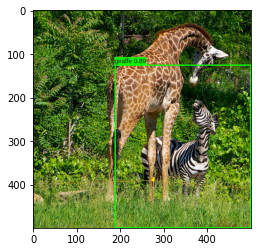

In [50]:
out_scores, out_boxes, out_classes = yolo_predict(yolo_model, 'giraffe.jpg')

**Expected Output**:
```
Found 8  boxes for  test.jpg
car 0.60 (911, 293) (1069, 360)
car 0.62 (756, 273) (977, 379)
car 0.66 (698, 283) (825, 328)
bus 0.67 (2, 268) (252, 389)
car 0.70 (777, 419) (1280, 611)
car 0.74 (134, 317) (378, 422)
car 0.80 (703, 315) (934, 416)
car 0.89 (263, 358) (882, 571)
```

The model you've just run is actually able to detect 80 different classes in "coco dataset". To test the model on your own images:

    1. Add your image to this Jupyter Notebook's directory, in the "images" folder
    2. Write your image's name in the cell above code
    3. Run the code and see the output of the algorithm!


## What you should remember:
    
- YOLO is a state-of-the-art object detection model that is fast and accurate
- It runs an input image through a CNN which outputs a 19x19x5x85 dimensional volume. 
- The encoding can be seen as a grid where each of the 19x19 cells contains information about 5 boxes.
- You filter through all the boxes using non-max suppression. Specifically: 
    - Score thresholding on the probability of detecting a class to keep only accurate (high probability) boxes
    - Intersection over Union (IoU) thresholding to eliminate overlapping boxes
- Because training a YOLO model from randomly initialized weights is non-trivial and requires a large dataset as well as lot of computation, we used previously trained model parameters in this exercise. If you wish, you can also try fine-tuning the YOLO model with your own dataset, though this would be a fairly non-trivial exercise. 

**References**: The ideas presented in this notebook came primarily from the two YOLO papers. The implementation here also took significant inspiration and used many components from Allan Zelener's GitHub repository. The pre-trained weights used in this exercise came from the official YOLO website. 
- Joseph Redmon, Santosh Divvala, Ross Girshick, Ali Farhadi - [You Only Look Once: Unified, Real-Time Object Detection](https://arxiv.org/abs/1506.02640) (2015)
- Joseph Redmon, Ali Farhadi - [YOLO9000: Better, Faster, Stronger](https://arxiv.org/abs/1612.08242) (2016)
- Allan Zelener - [YAD2K: Yet Another Darknet 2 Keras](https://github.com/allanzelener/YAD2K)
- The official YOLO website (https://pjreddie.com/darknet/yolo/) 